In [94]:
import numpy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numba as nb

In [70]:
G = 0.1
dt = 0.01

In [71]:
class Item:
    """
    The class describes item parameter in space.

    Attributes
    ----------
    m : float64
        Mass
        
    r : np.ndarray
        The coordinate of the body at the last moment of time

    v : np.ndarray
        The speed of the body at the last moment of time

    name : str
        Name of the object

    type : str
        The type of curve along which the body moves
        
    history : np.ndarray
        A list of all the coordinates the body has visited
    """
    def __init__(self, m: float, r0: np.ndarray, v0: np.ndarray, name):
        self.name = name
        self.m = m
        self.v = v0
        self.r = r0
        self.type = None
        self.history = np.array(self.r, dtype=np.float)

    def __str__(self):
        """
        The auxiliary function to show information about body's parameters.

        Returns
        -------
        out : string
        """
        if type is not None:
            return f'mass:{np.round(self.m, 2)}, Coordinates:{np.round(self.r, 2)}, type:{self.type}'
        else:
            return f'mass:{np.round(self.m, 2)}, Coordinates:{np.round(self.r, 2)}'

    def kin(self):
        """
        A function that counts the kinetic energy of an object
        
        Returns:
        -------
        out : float64
        """
        return self.m * np.linalg.norm(self.v) ** 2 / 2

@nb.njit(fastmath=True, nogil = True)
def energy_two(m0, m1, r0, r1) -> np.float64:
    """
    The function counts the energy between two bodies
    
    Parameters: m0 -> np.float64
                m1 -> np.float64
                r0 -> np.float64
                r1 -> np.float64
                
    Returns:
    -------
    out: np.float64
    """
    return  - G * m0 * m1 / np.linalg.norm(r0 - r1)

def pot_energy(it : Item, items : list) -> np.float64:
    """
    This function calculates the energy of the potential interaction of one body with the entire system.
    
    Parameters: it -> Item
                    The body whose energy we want to count
                items -> list
                    Other bodies
    
    Returns:
    --------
    out: np.float64
    """
    E = 0
    for i in items:
        E += energy_two(it.m, i.m, it.r, i.r)
    return E

def full_energy(items : list) -> np.float64:
    """
    A function that counts the total energy of the system
    
    Parameters: items -> list
    
    Returns:
    -------
    out : np.float64
    """
    energy = 0.
    for i in items:
        energy += i.kin()

    for j in range(len(items)):
        flg = j+1
        while flg < len(items):
            energy += energy_two(items[j].m, items[flg].m, items[j].r, items[flg].r)
            flg+=1
            
    return np.fabs(energy)

In [72]:
@nb.njit(fastmath=True, nogil = True)
def speed_change(m : np.float64, r1 : np.float64, r2 : np.float64) -> np.float64:
    """
    A function that determines the change in the velocity of the body_1 during the time dt,
    created due to the action of a force from another body_2.
    
    Parameters: m -> np.float64
                r1 -> np.float64
                r2 -> np.float64
                
    Returns:
    --------
    out : np.float64
    """
    return -dt * G * m * (r2 - r1) / np.linalg.norm(r2 - r1) ** 3

def step(items):
    """
    This function registers changes in the system that occur during dt.
    Parameters: items -> list
    """
    for i in range(len(items)):
        for j in range(len(items)):
            if j != i:
                dv = speed_change(items[j].m, items[j].r, items[i].r)
                items[i].v += dv

    for i in items:
        i.r += i.v * dt
        i.history = np.vstack((i.history, i.r))
    
    #destroy
    for j in range(len(items)):
        k = j+1
        while k < len(items):
            if (items[j].r == items[k].r).sum() == 3:
                items.remove(items[j])
                items.remove(items[k])
            k+=1

In [73]:
def test_зсэ(items, k, stop):
    """
    This function is needed to check the feasibility of the law of conservation of energy.
    
    Parameters: items -> list
                    just list of objects
                k -> np.float64
                    the value by which the maximum can deviate from the initial total energy
                    
                stop -> np.int64
                    the maximum value of iterations in case the energy has not gone beyond what is allowed
    Returns:
    --------
        out: num of iterations
    """
    o = full_energy(items)
    cnt = 0
    t = 0
    while (np.fabs(full_energy(items) - o) < o * k) and (cnt < stop):
        cnt += 1
        step(items)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    for x in items:
        ax.scatter(x.history[:, 0], x.history[:, 1], x.history[:, 2], label = x.name)
    ax.legend()
    print('number of iterations:{}, initial total energy:{}, final total energy:{}'.format(cnt, o, full_energy(items)))

number of iterations:1000, initial total energy:39.293702744878864, final total energy:39.293702744878864


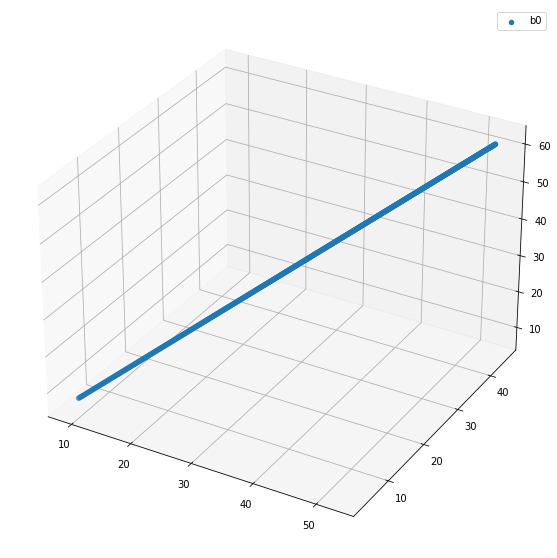

In [74]:
def test_of_gen_one_object():
    """
    This function tests the creation and existence of a single object.
    """
    b0 = Item(np.random.rand()*10, np.random.rand(3)*10, np.random.rand(3)*10, 'b0')
    it = [b0]
    test_зсэ(it, 0.01, 1000)
test_of_gen_one_object()

number of iterations:2000, initial total energy:561.561737618886, final total energy:564.6680099140124


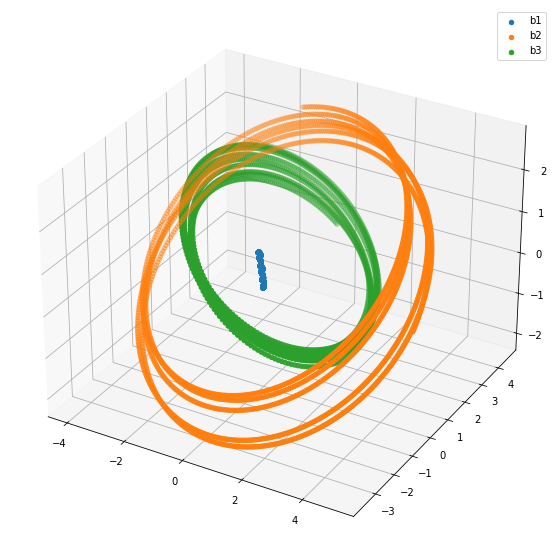

In [75]:
def interaction_test():
    """
    Test of the law of conservation of energy and correct interaction of particles.
    """
    b1 = Item(2000, np.random.rand(3) * 0, np.random.rand(3) * 0, 'b1')
    b2 = Item(10, np.array([5., 0., 0]), np.array([0., 5., 3.]), 'b2')
    b3 = Item(10, np.array([0., 4., 0]), np.array([-5., 0., 3.]), 'b3')
    it = [b1, b2, b3]
    test_зсэ(it, 0.01, 2000)
interaction_test()

In [76]:
def trajectoty_type(items : list) -> list:
    """
    This function determines the type of trajectory of each body
        Parameters: items -> list
                        just list of objects
        Returns:
        --------
            out: names of objects and their trajectory type
    """
    total = []
    for i in range(len(items)):
        en = items[i].kin()
        for j in range(len(items)):
            if i != j:
                en += -G * items[i].m * items[j].m /np.linalg.norm(items[i].r - items[j].r)
        if en > 0:
            items[i].type = "hyperbole"
        elif np.fabs(en) < 15:
            items[i].type = "parabola"
        else:
            items[i].type = "ellipse"
        total.append(en)
    
    for i in items:
        print(f'name:{i.name}, type:{i.type}')

number of iterations:400, initial total energy:532.0171139964455, final total energy:527.2982096535511
name:b1, type:ellipse
name:b2, type:ellipse
name:b3, type:ellipse
name:b4, type:hyperbole
name:b5, type:parabola


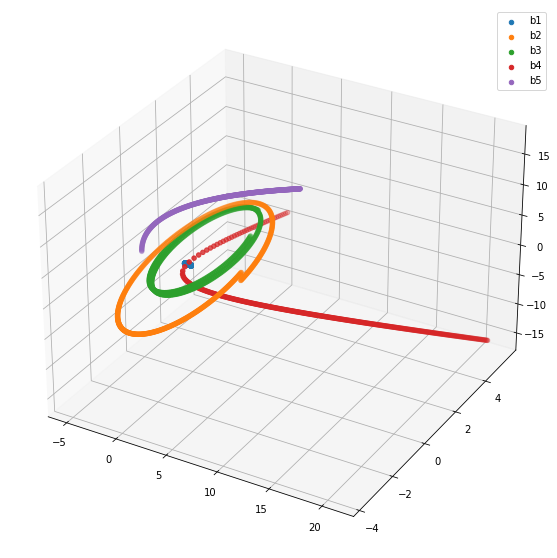

In [78]:
def test_trajectory():
    """
    This function tests the correctness of determining the trajectories of the movement of bodies.
    """
    m1, m2, m3, m4, m5 = 2000, 11, 12, 13, 10
    b1 = Item(m1, np.random.rand(3) * 0, np.random.rand(3) * 0, 'b1')
    b2 = Item(m2, np.array([5., 0., 0]), np.array([0., 5., 3.]), 'b2')
    b3 = Item(m3, np.array([0., 4., 0]), np.array([-5., 0., 3.]), 'b3')
    b4 = Item(m4, np.array([3., 4., 1]), np.array([-7., -7., 0.]), 'b4')
    it = [b1, b2, b3, b4]
    b5 = Item(m5, np.array([-5., 0., 0.]), np.array([0, 0., 0.]), 'b5')
    b5.v[2]+=np.sqrt(-2*pot_energy(b5, it)/m5) 
    it.append(b5)
    test_зсэ(it, 6, 400)
    trajectoty_type(it)
    
test_trajectory()

In [97]:
class u_test(unittest.TestCase):
    def init_(self):
        b = Item(10, np.array([5., 0., 0]), np.array([0., 5., 3.]), 'b')
        self.assertEqual(b.m, 10)
        self.assertEqual(b.r.tolist(), [5., 0., 0.])
        self.assertEqual(b.v.tolist(), [0., 5., 3.])
        delf.assertEqual(b.name, 'b')


if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)


----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK
